In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# loading keras and FBD experiment...
from keras import backend as K
from helpers import *
from experiment_model import *
from model_conv import *
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
import sys
import numpy as np

# to show the model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import Model, Input

# loading resnet
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

Using TensorFlow backend.


Initialized TensorFlow


### The issue:
1. MNIST convnet works with avgpool/maxpool and with 3 channels
2. ImageNet doesn't work even for one conv layer and downsampled to 2x2 pixels input (see VGG16 notebook) both for vgg16 and resnet
3. Looks like the problem is in `preprocess_input`. It makes $\mathbb{E}_ix_i=0$. Tried removing it. VGG still works and the bound still doesn't. Maybe the problem is that it's rare that a pixel becomes of different color? Maybe I need to kill all 3 channels at once? Or I need to use AvgPooling? Even 1 Conv layer with flattened output cannot be handled by the bound
4. Which assumption is not correct? Is it the issue with input dimensionality? Try only crashing first row of the image...

In [2]:
# see https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# channels last
# Making images grayscale (adding repeated 2 more channels)
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1).repeat(3, axis = 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1).repeat(3, axis = 3)

In [4]:
# printing shapes
x_test.shape, x_train.shape

((10000, 28, 28, 3), (60000, 28, 28, 3))

In [5]:
input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 3)
60000 train samples
10000 test samples


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 94us/step - loss: 2.3208 - acc: 0.1084 - val_loss: 2.3008 - val_acc: 0.1135
Epoch 2/10
60000/60000 [==============================] - 5s 86us/step - loss: 1.7512 - acc: 0.3403 - val_loss: 0.1380 - val_acc: 0.9565
Epoch 3/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.1497 - acc: 0.9553 - val_loss: 0.0550 - val_acc: 0.9822
Epoch 4/10
60000/60000 [==============================] - 5s 90us/step - loss: 0.0943 - acc: 0.9725 - val_loss: 0.0374 - val_acc: 0.9871
Epoch 5/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0723 - acc: 0.9791 - val_loss: 0.0297 - val_acc: 0.9906
Epoch 6/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.0625 - acc: 0.9813 - val_loss: 0.0277 - val_acc: 0.9894
Epoch 7/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.0544 - acc: 0.9841 - val_loss: 0.0258 - val_acc

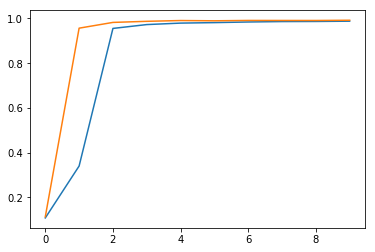

Test loss: 0.02345964987495172
Test accuracy: 0.9919


In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='softplus',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='softplus'))
#model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding = 'same', activation='softplus'))
model.add(Conv2D(64, (3, 3), padding = 'same', activation='softplus'))
#model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='softplus'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
plt.figure()
plt.plot(history.history['acc'], label = 'acc')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.show()
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [7]:
# probability of input failure
p = 0.0001

# calculating n
n = np.prod(list(map(int, model.inputs[0].shape[1:])))

# n, p, np
print(n, p, n * p)

2352 0.0001 0.23520000000000002


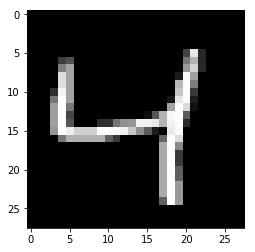

In [8]:
# obtain input
x = np.array([x_train[2]])
plt.imshow(x[0])
plt.show()

In [9]:
# obtaining experiment from a model
exp = ModelInputCrashExperiment(model, p = p)

In [10]:
def predict(model, x):
    """ Predict classes, order by most probable """
    preds = model.predict(x)[0]
    sort = np.argsort(-preds)[:3]
    print(' '.join(['%d: %.20f%%' % (i, 100 * preds[i]) for i in sort]))

In [11]:
# crashing prediction
predict(exp.model_crashing, x)

4: 99.99997615814208984375% 9: 0.00002134309937673606% 1: 0.00000298075875093673%


In [12]:
# correct prediction
predict(exp.model_correct, x)

4: 99.99997615814208984375% 9: 0.00002134309937673606% 1: 0.00000298075875093673%


In [13]:
# theoretical error
exp.get_bound_b3(x)

{'mean': array([ 5.3206518e-16,  7.2949806e-11,  5.5989449e-12,  2.0818543e-15,
        -4.9569471e-10,  3.8605739e-14,  6.7472881e-12,  3.3007912e-11,
         1.7755918e-13,  4.2561382e-10], dtype=float32),
 'std': array([6.0661882e-15, 1.0045154e-09, 6.4685222e-11, 2.4253818e-14,
        5.7991980e-09, 4.7914548e-13, 8.5031572e-11, 3.7187320e-10,
        2.0881448e-12, 5.0924123e-09], dtype=float32)}

In [14]:
# get experimental error
experiment_mean_std(exp, x, repetitions = 10000)

{'mean': array([[ 7.5416097e-16,  1.0058494e-10,  7.1183124e-12,  3.1662365e-15,
         -2.5033950e-10,  5.9061724e-14,  9.2576962e-12,  4.1548130e-11,
          2.4564606e-13,  5.4762639e-10]], dtype=float32),
 'std': array([[8.8094501e-15, 1.3049956e-09, 8.5166041e-11, 3.9030496e-14,
         7.4399971e-09, 7.5031772e-13, 1.1716579e-10, 4.6027468e-10,
         2.8889861e-12, 5.9992353e-09]], dtype=float32)}